# DNN

In [56]:
# !pip install torchmetrics

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# !pip install torchmetrics
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

In [58]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [59]:
df = pd.read_csv('./landslides_with_variables_cleaned.csv').drop(columns=['ID'])
df.head()

,Valid Landslide,Latitude,Longitude,CURVATURE,TWI,SLOPE_deg,DEM,SLOPE_deg.1,ASPECT_deg,LANDCOVER_CODE,ASPECT_rad,ASPECT_sin,ASPECT_cos,SLOPE_rad
0,1,-36.819859,174.746298,1.379645,5.286413,11.441814,18.809872,11.441814,222.978638,1.0,3.891711,-0.681726,-0.731608,0.199697
1,1,-36.798134,174.684934,0.190541,6.555068,14.671361,19.514647,14.671361,166.090866,1.0,2.898832,0.240383,-0.970678,0.256064
2,1,-36.932751,174.744548,0.068507,9.921234,17.020342,22.542194,17.020342,158.192902,11.0,2.760987,0.371483,-0.928440,0.297061
3,1,-36.852885,174.792092,0.528753,3.760681,29.180260,24.194622,29.180260,59.103947,11.0,1.031558,0.858100,0.513482,0.509292
4,1,-36.809204,174.718141,-0.087607,5.854521,15.388130,69.367027,15.388130,57.325916,1.0,1.000526,0.841755,0.539860,0.268574


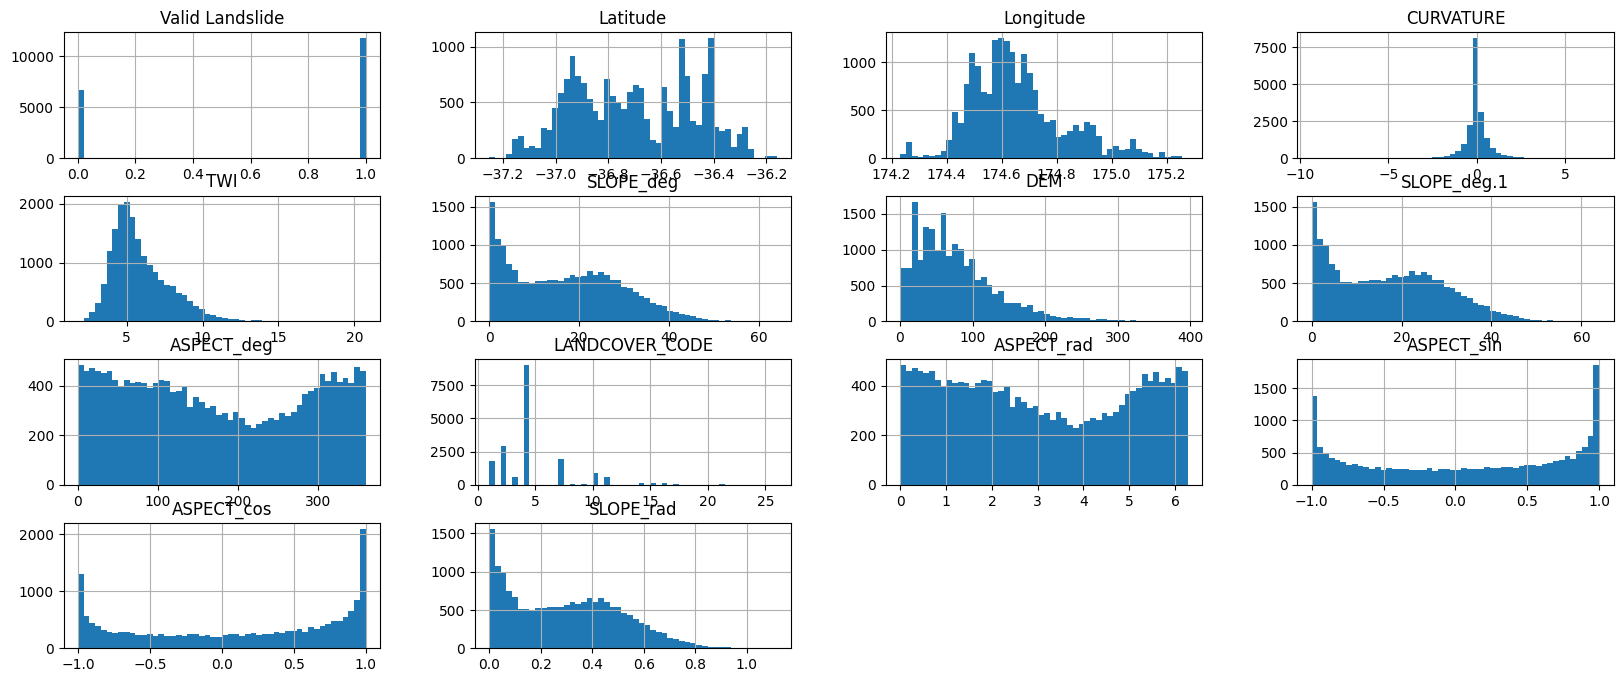

In [60]:
df.hist(bins=50, figsize=(20, 8))
plt.show()

## Spliting

In [61]:
# 1. Separate features (X) and target (y)
df['LANDCOVER_CODE'] = df['LANDCOVER_CODE'].astype(str)

X = df.drop(columns=["Valid Landslide", "Latitude", "Longitude"])
y = df["Valid Landslide"].copy()

# 2. Split data into training and testing sets
# 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=random_seed, stratify=y_train)


## Data Processing Pipeline

In [62]:
# Define pipelines
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(
    StandardScaler())

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

set_config(display='diagram')
preprocessing

,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [63]:
X_train_prepared = preprocessing.fit_transform(X_train)
X_valid_prepared = preprocessing.transform(X_valid)
X_test_prepared = preprocessing.transform(X_test)

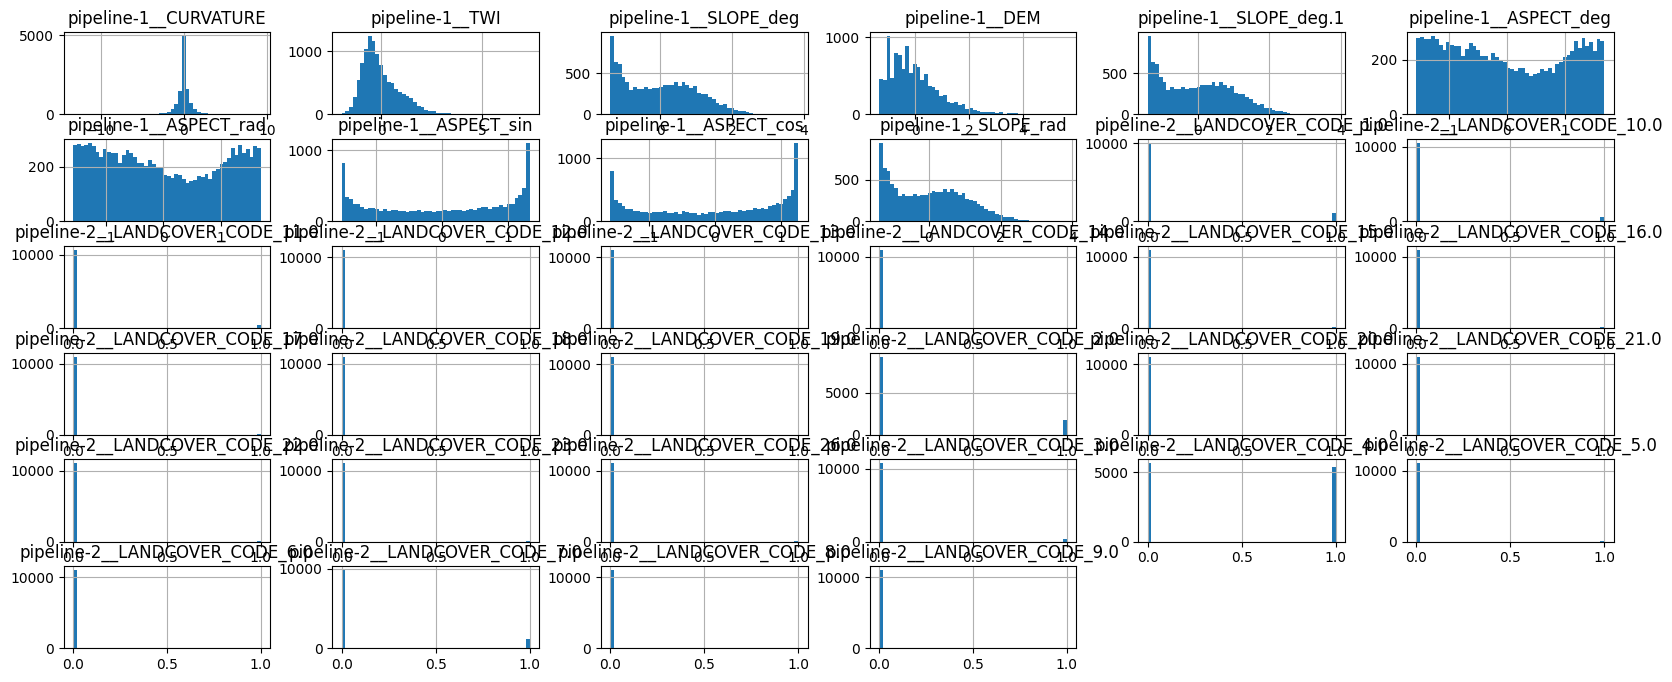

In [64]:
# (Optional) Display the transformed training data
df_prepared = pd.DataFrame(X_train_prepared,
                           columns=preprocessing.get_feature_names_out(),
                           index=X_train.index)

df_prepared.hist(bins=50, figsize=(20, 8))
plt.show()

## Train the model

In [86]:
batch_size = 64

X_valid_tensor = torch.tensor(X_valid_prepared, dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)
X_train_tensor = torch.tensor(X_train_prepared, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_prepared, dtype=torch.float32) 
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Now create the TensorDataset with the correct data types
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [99]:
def train(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        #Training
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_batch = y_train_batch.float().unsqueeze(1)
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)

        # Validation
        model.eval()
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_batch = y_valid_batch.float().unsqueeze(1)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")

    return (train_losses, valid_losses)

In [100]:
def set_model():
  n_attributes = X_valid_tensor.shape[1]
  n_outputs = 1
  model = nn.Sequential(
  nn.Linear(n_attributes, 50),
  nn.ReLU(),
  nn.Linear(50, 40),
  nn.ReLU(),
  nn.Linear(40, n_outputs)
  )
  return model

model = set_model().to(device)

In [106]:
model = set_model().to(device)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.BCEWithLogitsLoss()
n_epochs = 50

In [107]:
train_losses, valid_losses = train(
    model, optimizer, loss, train_loader, valid_loader, n_epochs)

Epoch 1/50, Training Loss: 0.6645, Valid Loss: 0.6387
Epoch 2/50, Training Loss: 0.6101, Valid Loss: 0.5810
Epoch 3/50, Training Loss: 0.5437, Valid Loss: 0.5135
Epoch 4/50, Training Loss: 0.4763, Valid Loss: 0.4559
Epoch 5/50, Training Loss: 0.4279, Valid Loss: 0.4235
Epoch 6/50, Training Loss: 0.4037, Valid Loss: 0.4103
Epoch 7/50, Training Loss: 0.3919, Valid Loss: 0.4008
Epoch 8/50, Training Loss: 0.3843, Valid Loss: 0.3933
Epoch 9/50, Training Loss: 0.3778, Valid Loss: 0.3863
Epoch 10/50, Training Loss: 0.3724, Valid Loss: 0.3804
Epoch 11/50, Training Loss: 0.3669, Valid Loss: 0.3736
Epoch 12/50, Training Loss: 0.3627, Valid Loss: 0.3690
Epoch 13/50, Training Loss: 0.3591, Valid Loss: 0.3638
Epoch 14/50, Training Loss: 0.3564, Valid Loss: 0.3607
Epoch 15/50, Training Loss: 0.3542, Valid Loss: 0.3595
Epoch 16/50, Training Loss: 0.3527, Valid Loss: 0.3560
Epoch 17/50, Training Loss: 0.3509, Valid Loss: 0.3547
Epoch 18/50, Training Loss: 0.3497, Valid Loss: 0.3524
Epoch 19/50, Traini

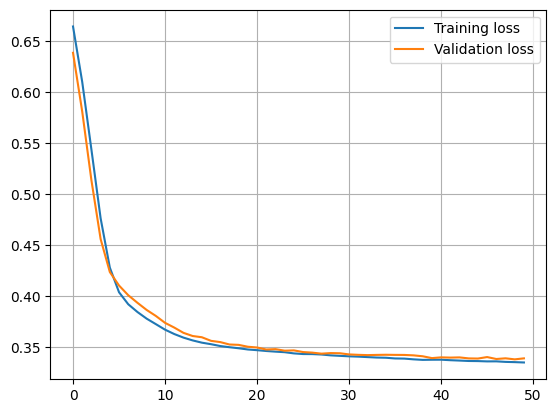

In [108]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.grid()
plt.legend()

In [109]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            # Get the raw model outputs (logits)
            test_outputs = model(X_test_batch)
            
            # Apply sigmoid to get probabilities and then round to get predictions
            predicted = torch.round(torch.sigmoid(test_outputs))
            
            total += y_test_batch.size(0)
            correct += (predicted.squeeze() == y_test_batch).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
test_accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 84.88%
